# Land Cover Classification using Deep Learning Techniques and EuroSAT

## Mounting google drive for dataset access and saving models

## Libraries

In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 285 µs (started: 2024-04-28 19:21:04 +00:00)


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns
import random


from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import train_test_split


import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

import matplotlib
matplotlib.rcParams['axes.grid'] = False

time: 7.11 s (started: 2024-04-28 19:21:04 +00:00)


## Config

In [3]:
ROOT_PATH = './'
BASE_PATH = '/kaggle/input/cifar10-wgan-augmented/cifar10_original_all/cifar10_raw/images/train'
FULL_DATA_DF = os.path.join(ROOT_PATH, 'dataset_label.csv')

IDX_CLASS_LABELS = {
    0: 'Airplane',
    1: 'Automobile', 
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}
CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog','Frog','Horse','Ship', 'Truck']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
  CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(1021)
TEST_SIZE = 0.25

#approach = "Resnet"

time: 4.37 ms (started: 2024-04-28 19:21:11 +00:00)


## Utils

In [4]:
## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

## Show batches of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

time: 3.19 ms (started: 2024-04-28 19:21:11 +00:00)


In [5]:
## Example for decoding and encoding
print(encode_label('Airplane'))
print(decode_target(1))
print(decode_target(2, text_labels=True))

0
Automobile
Bird
time: 7.11 ms (started: 2024-04-28 19:21:11 +00:00)


## Pre-Processing data folders to train and test
Run this code cells only if you don't have the required dataframe

In [6]:
print(f"Total number of images in the dataset: {len(os.listdir(BASE_PATH))}")

Total number of images in the dataset: 10
time: 17.8 ms (started: 2024-04-28 19:21:11 +00:00)


In [7]:
from os import walk

i = 0
DATA_DF = pd.DataFrame(columns = ['image_id', 'label']) 

# for (dirpath, dirname, filename) in walk(BASE_PATH):
#   for each_file in filename:

for class_name in CLASSES:  # Iterate over class names
    class_path = os.path.join(BASE_PATH, class_name)
    for each_file in os.listdir(class_path):  # Iterate over images in each class folder
        DATA_DF.loc[i] = [each_file, class_name]  # Use class_name as label
        i += 1
    print(i)
DATA_DF.to_csv(FULL_DATA_DF, index=False)
DATA_DF.head()


6600
13200
19800
26400
33000
39600
46200
52800
59400
66000


,image_id,label
0,airliner_s_002037.png,Airplane
1,dive_bomber_s_000386.png,Airplane
2,Airplane_455.png,Airplane
3,stealth_fighter_s_001343.png,Airplane
4,twinjet_s_000835.png,Airplane


time: 1min 52s (started: 2024-04-28 19:21:11 +00:00)


In [8]:
print(f"Uniques values for labels are...")
for ind, each in enumerate(DATA_DF.label.unique()):
  print(ind+1, ":", each)

Uniques values for labels are...
1 : Airplane
2 : Automobile
3 : Bird
4 : Cat
5 : Deer
6 : Dog
7 : Frog
8 : Horse
9 : Ship
10 : Truck
time: 7.74 ms (started: 2024-04-28 19:23:04 +00:00)


## Processing data folders to train and test


In [9]:
DATA_DF = pd.read_csv(FULL_DATA_DF)
DATA_DF = DATA_DF.sample(frac = 1, random_state=48) 
TRAIN_DF = DATA_DF[:-int(len(DATA_DF)*TEST_SIZE)]
TEST_DF = DATA_DF[-int(len(DATA_DF)*TEST_SIZE) :]

time: 68.2 ms (started: 2024-04-28 19:23:04 +00:00)


In [10]:
TRAIN_DF.reset_index(inplace = True) 
TRAIN_DF.head()

,index,image_id,label
0,58526,boat_s_001908.png,Ship
1,55081,tank_ship_s_000784.png,Ship
2,52399,arabian_s_002168.png,Horse
3,7985,auto_s_000525.png,Automobile
4,38536,puppy_s_001517.png,Dog


time: 8.11 ms (started: 2024-04-28 19:23:04 +00:00)


In [11]:
TEST_DF.reset_index(inplace = True) 
TEST_DF.head()

,index,image_id,label
0,61073,trucking_rig_s_001186.png,Truck
1,38486,mongrel_s_002661.png,Dog
2,38289,toy_spaniel_s_000960.png,Dog
3,3714,twinjet_s_001419.png,Airplane
4,27122,barking_deer_s_000339.png,Deer


time: 8.51 ms (started: 2024-04-28 19:23:04 +00:00)


In [12]:
len(TRAIN_DF.index), len(TEST_DF.index)

(49500, 16500)

time: 4.81 ms (started: 2024-04-28 19:23:04 +00:00)


## Creating Dataset and Dataloaders

Now we will Create custom dataset by extending pytorch Dataset class. We also add provision for adding transformers for data augmentation.

In [13]:
class Cifar10(Dataset):
    def __init__(self, df, dirc, transform=None):
        self.train_dir = dirc
        self.train_df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.iloc[idx]
        img_id, label = row['image_id'], row['label']
        class_dir = os.path.join(self.train_dir, label)  # Directory for the specific class
        img_path = os.path.join(class_dir, img_id)      # Full path to the image
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

time: 2.13 ms (started: 2024-04-28 19:23:04 +00:00)


### Transformations and Datasets

In [14]:
## Dataset and transformations
train_data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(20),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.ToTensor(),
                                ])

test_data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
                                transforms.ToTensor(),
                                ])

time: 3.6 ms (started: 2024-04-28 19:23:04 +00:00)


In [15]:
train_ds = Cifar10(TRAIN_DF, BASE_PATH, train_data_transform)
test_ds = Cifar10(TEST_DF, BASE_PATH, test_data_transform)
print(len(train_ds), len(test_ds))

49500 16500
time: 9.63 ms (started: 2024-04-28 19:23:04 +00:00)


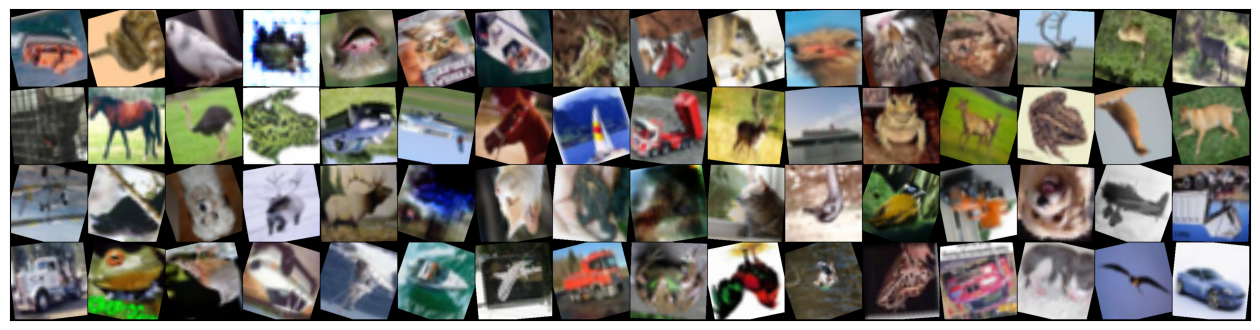

time: 2.38 s (started: 2024-04-28 19:23:04 +00:00)


In [16]:
## Data loaders and showing batch of data
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
show_batch(train_dl)

## Model

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss

    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

time: 1.97 ms (started: 2024-04-28 19:23:06 +00:00)


In [18]:
class LULC_Model(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = models.vgg16(pretrained=True)
        n_inputs = self.network.classifier[6].in_features
        self.network.classifier[6] = nn.Sequential(
                                      nn.Linear(n_inputs, 256),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(256, NUM_CLASSES),
                                      nn.LogSoftmax(dim=1)
                                        )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.classifier[6].parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

time: 7.09 ms (started: 2024-04-28 19:23:06 +00:00)


In [19]:
model = LULC_Model()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 167MB/s]  


time: 5.13 s (started: 2024-04-28 19:23:06 +00:00)


In [20]:
## Running through the data loader => Model => Output
def try_batch(dl):
    for images, labels in dl:  
        print(images.shape)
        out = model(images)
        print(out.shape)
        print(out[0])
        break
        
try_batch(train_dl)

torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.0236, -2.2109, -2.0844, -2.3190, -2.2919, -2.4586, -2.2136, -2.4471,
        -2.5213, -2.6224], grad_fn=<SelectBackward0>)
time: 27.2 s (started: 2024-04-28 19:23:12 +00:00)


## Training and Evaluating

In [21]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):
  
    history = []
    valid_loss_min = np.Inf
    valid_acc_max = 0
    model_file_name = 'lulc.pth'
    model_file_name2 = 'lulc_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
                         
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):
            
            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
            
            
        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############                                         
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history                                
                                                 
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

time: 3.32 ms (started: 2024-04-28 19:23:39 +00:00)


## Initializing Device also Loading Data and Model to device¶


In [22]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
        
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

time: 10.1 ms (started: 2024-04-28 19:23:39 +00:00)


In [23]:
device = get_device()
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
## Loading model to device
model = to_device(LULC_Model(), device)
## lets try passing a batch to model again
try_batch(train_dl)

True
torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.3346, -2.1163, -2.5475, -2.4184, -2.5298, -2.1371, -2.3096, -2.1854,
        -2.0507, -2.5601], device='cuda:0', grad_fn=<SelectBackward0>)
time: 3.6 s (started: 2024-04-28 19:23:39 +00:00)


In [24]:
torch.cuda.empty_cache()

time: 72.3 ms (started: 2024-04-28 19:23:42 +00:00)


## Training

In [25]:
## Hyper Parameters
max_epochs_stop = 5
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 0
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 25
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model, test_dl)

{'val_loss': 2.318500280380249, 'val_acc': 0.11213289946317673}

time: 52.1 s (started: 2024-04-28 19:23:42 +00:00)


In [26]:
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, test_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.6301, learning_rate: 0.0001, train_loss: 1.0492, val_loss: 0.5843, val_acc: 0.7999


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.8068, learning_rate: 0.0001, train_loss: 0.5726, val_loss: 0.4081, val_acc: 0.8611


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.8505, learning_rate: 0.0001, train_loss: 0.4496, val_loss: 0.3423, val_acc: 0.8845


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.8723, learning_rate: 0.0001, train_loss: 0.3835, val_loss: 0.3739, val_acc: 0.8793


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.8902, learning_rate: 0.0001, train_loss: 0.3328, val_loss: 0.3015, val_acc: 0.8977


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9013, learning_rate: 0.0001, train_loss: 0.3011, val_loss: 0.3846, val_acc: 0.8823


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9110, learning_rate: 0.0001, train_loss: 0.2681, val_loss: 0.2915, val_acc: 0.9048


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9150, learning_rate: 0.0001, train_loss: 0.2598, val_loss: 0.2985, val_acc: 0.9012


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9229, learning_rate: 0.0001, train_loss: 0.2291, val_loss: 0.2926, val_acc: 0.9045


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9293, learning_rate: 0.0001, train_loss: 0.2120, val_loss: 0.2816, val_acc: 0.9095


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9357, learning_rate: 0.0001, train_loss: 0.1957, val_loss: 0.2887, val_acc: 0.9078


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9376, learning_rate: 0.0001, train_loss: 0.1883, val_loss: 0.2999, val_acc: 0.9091


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.9413, learning_rate: 0.0001, train_loss: 0.1769, val_loss: 0.2558, val_acc: 0.9223


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.9463, learning_rate: 0.0001, train_loss: 0.1636, val_loss: 0.3012, val_acc: 0.9131


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.9489, learning_rate: 0.0001, train_loss: 0.1552, val_loss: 0.2985, val_acc: 0.9093


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.9510, learning_rate: 0.0001, train_loss: 0.1476, val_loss: 0.2703, val_acc: 0.9163


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.9767, learning_rate: 0.0000, train_loss: 0.0722, val_loss: 0.2373, val_acc: 0.9360


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.9814, learning_rate: 0.0000, train_loss: 0.0546, val_loss: 0.2380, val_acc: 0.9380


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.9842, learning_rate: 0.0000, train_loss: 0.0485, val_loss: 0.2374, val_acc: 0.9395


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.9858, learning_rate: 0.0000, train_loss: 0.0441, val_loss: 0.2340, val_acc: 0.9410


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [20],train_accu: 0.9878, learning_rate: 0.0000, train_loss: 0.0382, val_loss: 0.2450, val_acc: 0.9407


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [21],train_accu: 0.9885, learning_rate: 0.0000, train_loss: 0.0353, val_loss: 0.2489, val_acc: 0.9410


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [22],train_accu: 0.9901, learning_rate: 0.0000, train_loss: 0.0311, val_loss: 0.2623, val_acc: 0.9414


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [23],train_accu: 0.9918, learning_rate: 0.0000, train_loss: 0.0268, val_loss: 0.2557, val_acc: 0.9435


  0%|          | 0/774 [00:00<?, ?it/s]

Epoch [24],train_accu: 0.9924, learning_rate: 0.0000, train_loss: 0.0253, val_loss: 0.2551, val_acc: 0.9442
VAL LOSS MIN 0.23399178683757782
VAL ACC MAX 0.944180428981781
time: 2h 49min 20s (started: 2024-04-28 19:24:35 +00:00)


## Reports

### Training Reports

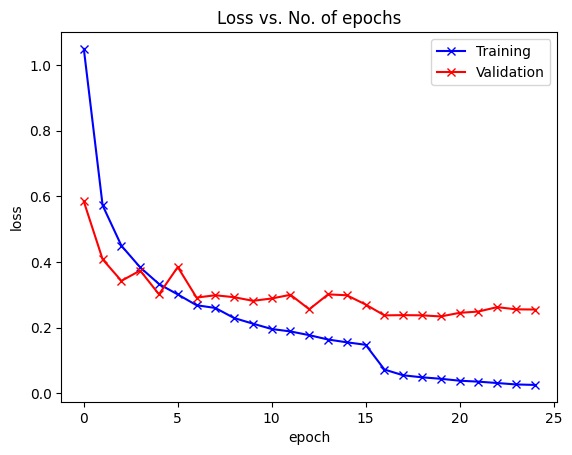

time: 338 ms (started: 2024-04-28 22:13:55 +00:00)


In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

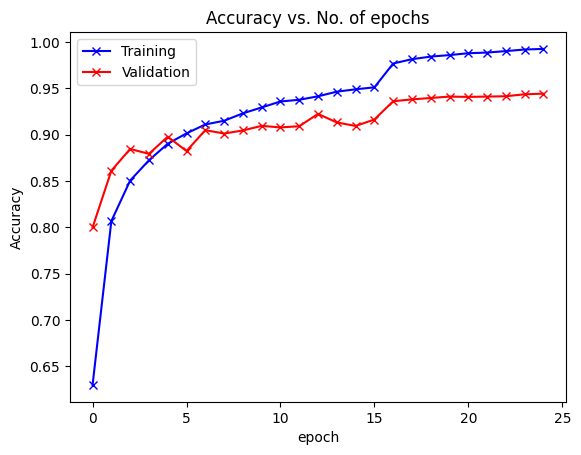

time: 331 ms (started: 2024-04-28 22:13:55 +00:00)


In [28]:
def plot_accuracy(history):
        
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracy(history)

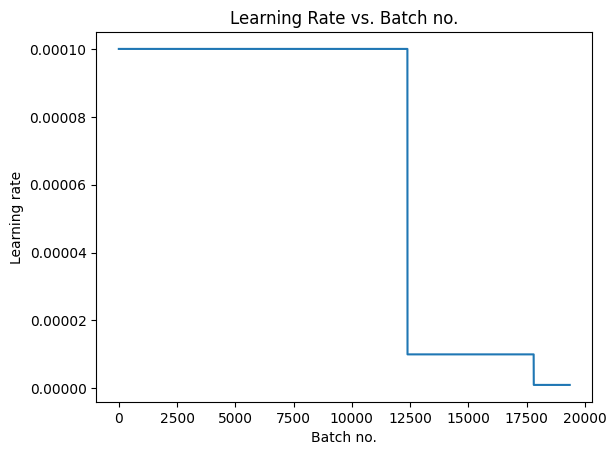

time: 236 ms (started: 2024-04-28 22:13:56 +00:00)


In [29]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

## Evaluation on test dataset

In [30]:
## Evaluation with best validation accuracy model
model = LULC_Model()
model.load_state_dict(torch.load("./lulc_max_acc.pth"))
model.eval()
model = to_device(model, device)

time: 2.44 s (started: 2024-04-28 22:13:56 +00:00)


In [31]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, labels = [], []
    for xb, label in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())     
        labels.append(label)   
    return [x for x in batch_pred], \
            [x for x in labels]

time: 852 µs (started: 2024-04-28 22:13:59 +00:00)


In [32]:
device = get_device()
## Loading data to devide
batch_size =1
test_dl = DataLoader(test_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

True
time: 6.61 ms (started: 2024-04-28 22:13:59 +00:00)


In [33]:
predictions, labels = predict_dl(test_dl, model)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]

  0%|          | 0/16500 [00:00<?, ?it/s]

time: 1min 27s (started: 2024-04-28 22:13:59 +00:00)


In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(labs, preds)
cm = cm / cm.astype(np.float64).sum(axis=1)
cm = np.round(cm, 4) * 100
acc = accuracy_score(labs, preds)
print(f'''Accuracy of test data is: {acc*100:.2f} %''' )

Accuracy of test data is: 94.42 %
time: 24.7 ms (started: 2024-04-28 22:15:26 +00:00)


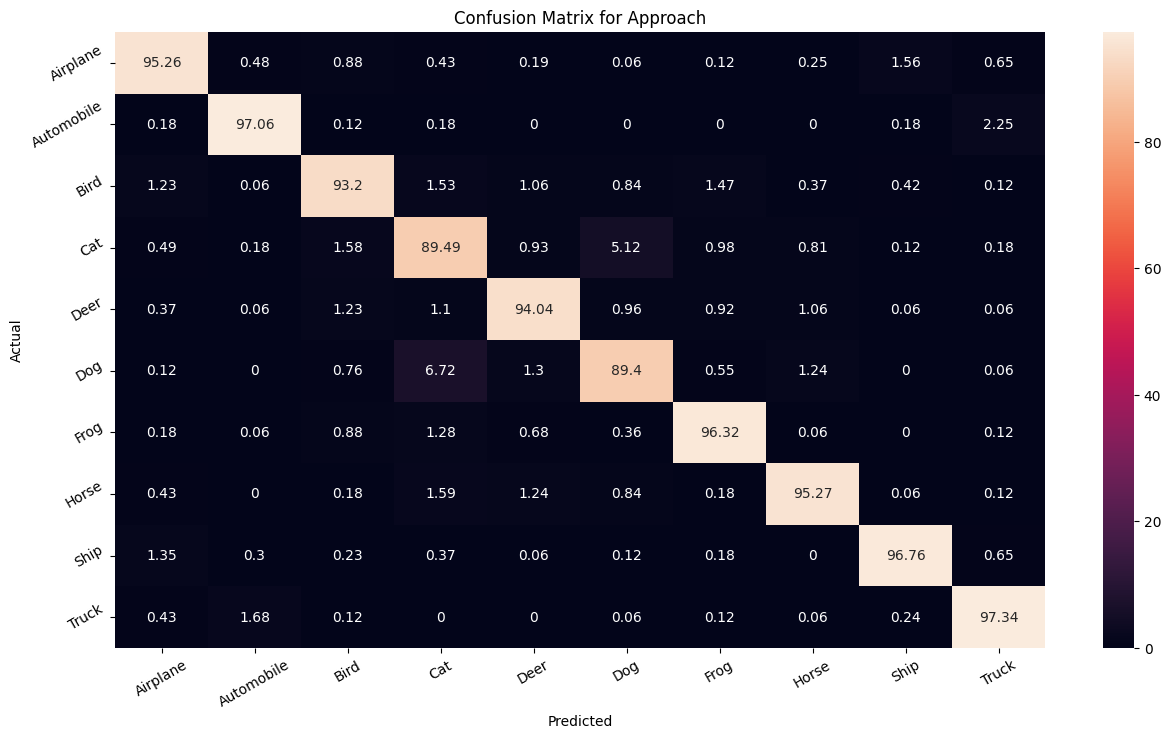

time: 605 ms (started: 2024-04-28 22:15:26 +00:00)


In [35]:
plt.figure(figsize = (15,8))
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title(f'Confusion Matrix for Approach');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.yticks(rotation=30) 
plt.xticks(rotation=30) 
## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(CLASSES)
ax.yaxis.set_ticklabels(CLASSES)
plt.show()

### Prediction Reports

<Figure size 640x480 with 0 Axes>

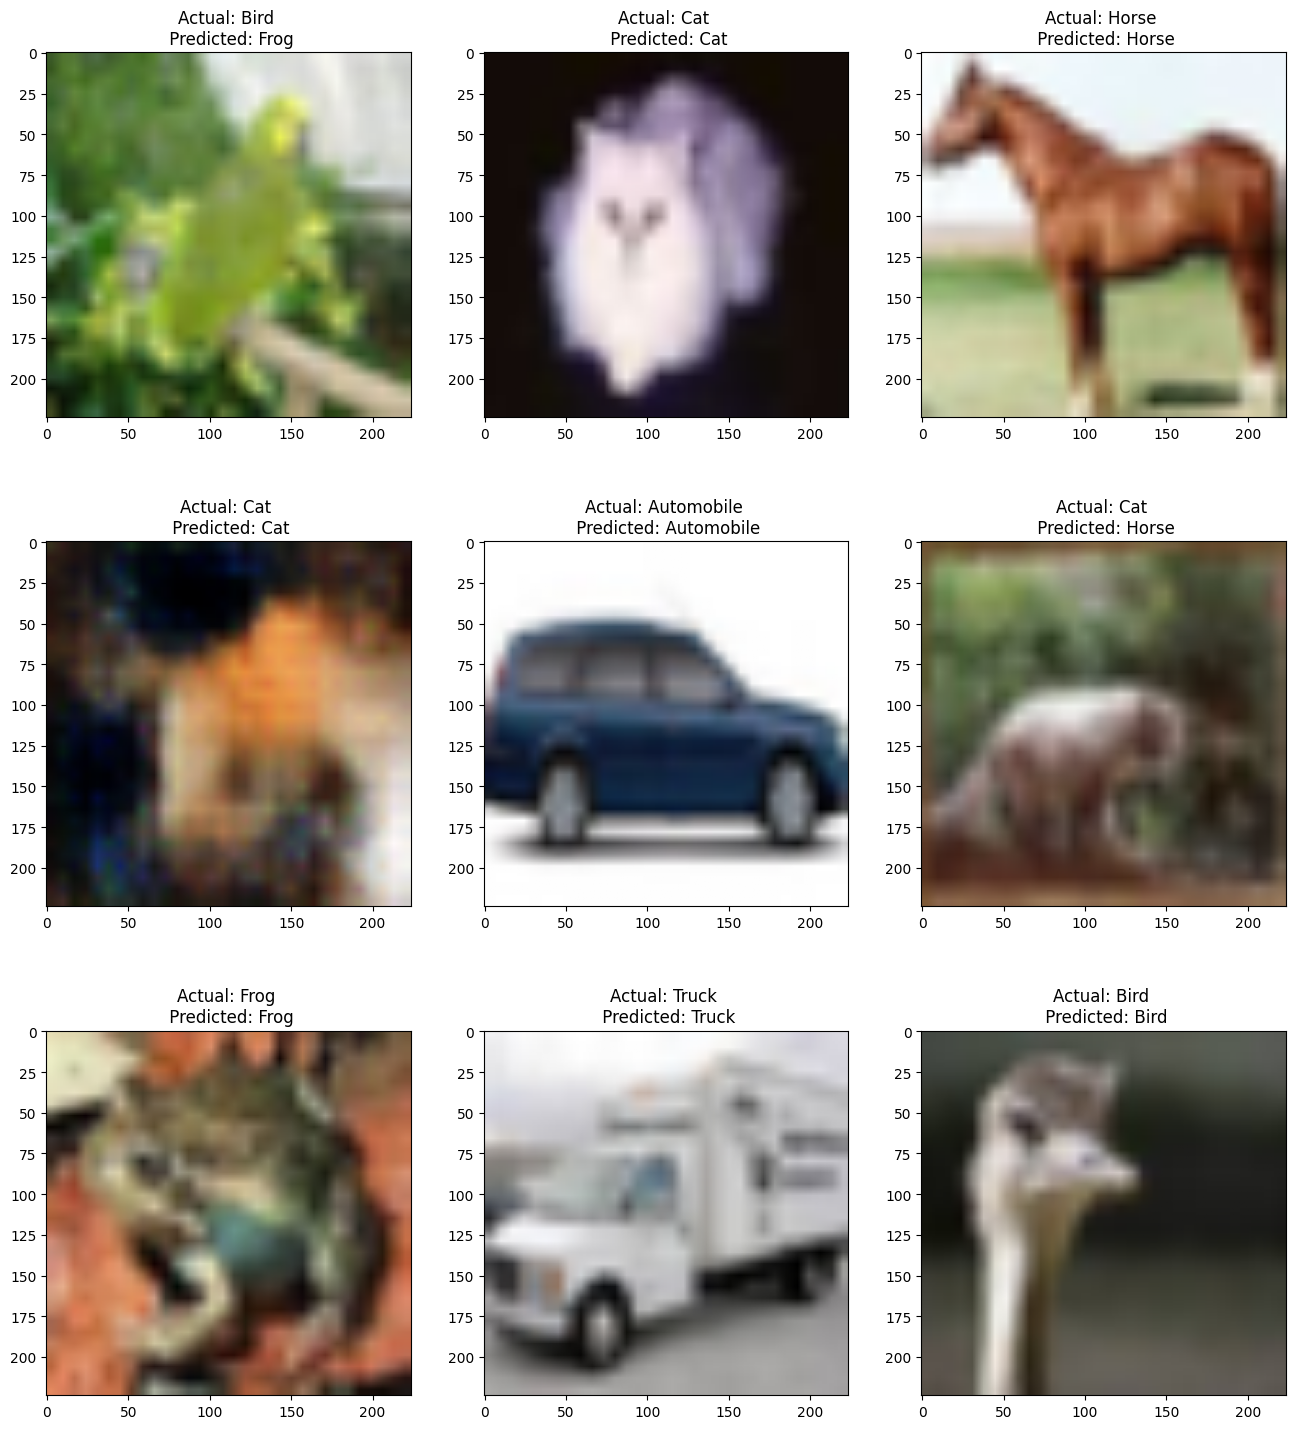

time: 3.17 s (started: 2024-04-28 22:15:27 +00:00)


In [36]:
### Predict Single Images
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    return decode_target(int(prediction), text_labels=True)

def plot_samples(img_dir, rows=3, cols=3):
    plt.figure()
    f, axs = plt.subplots(rows, cols, figsize=(16, 18))
    k = 120
    for i in range(rows):
        for j in range(cols):
            predicted = predict_single(test_ds[k][0])
            actual = decode_target(test_ds[k][1], text_labels=True)
            text = f"Actual: {actual} \n Predicted: {predicted}"
            axs[i, j].title.set_text(text)
            axs[i, j].imshow(test_ds[k][0].permute(1, 2, 0))
            
            k += 1

plot_samples(BASE_PATH)

# Evaluation on overall dataset

In [37]:
device = get_device()
## Loading data to devide
batch_size =1
test_ds = Cifar10(DATA_DF, BASE_PATH, test_data_transform)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

True
time: 1.32 ms (started: 2024-04-28 22:15:30 +00:00)


In [38]:
predictions, labels = predict_dl(test_dl, model)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]

  0%|          | 0/66000 [00:00<?, ?it/s]

time: 5min 50s (started: 2024-04-28 22:15:30 +00:00)


In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(labs, preds)
cm = cm / cm.astype(np.float64).sum(axis=1)
cm = np.round(cm, 4) * 100
acc = accuracy_score(labs, preds)
print(f'''Accuracy of overall data is: {acc*100:.2f} %''' )

Accuracy of overall data is: 98.39 %
time: 76 ms (started: 2024-04-28 22:21:20 +00:00)


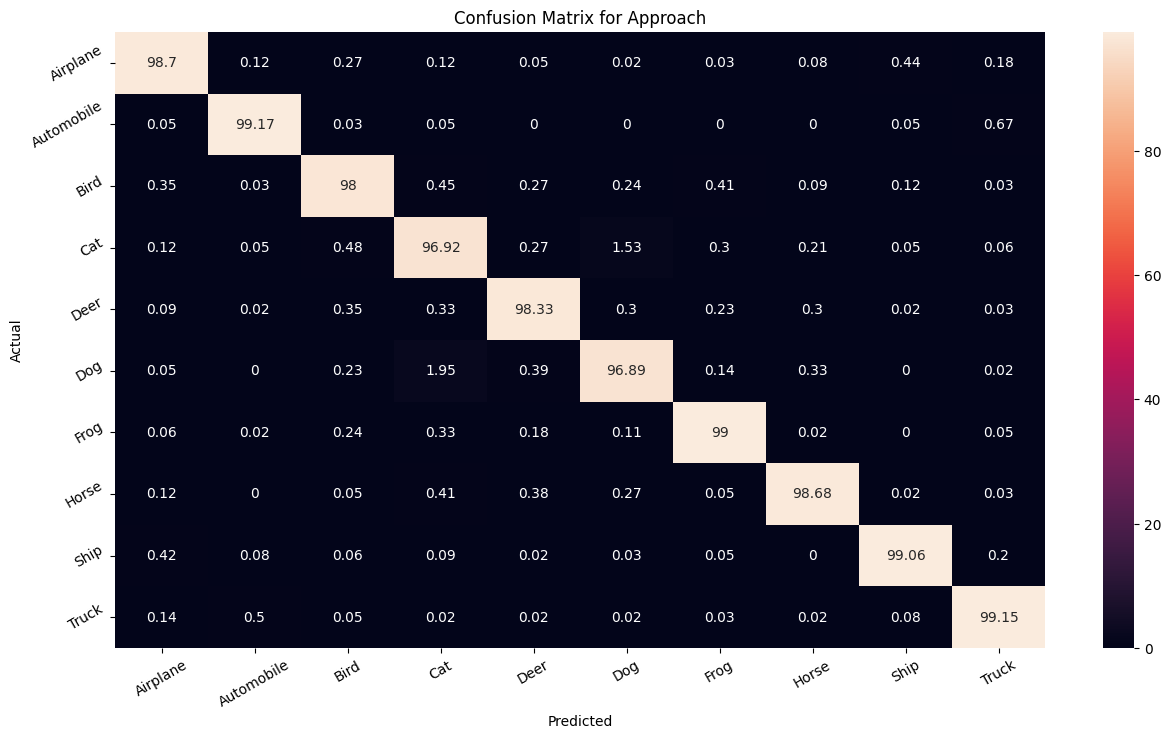

time: 611 ms (started: 2024-04-28 22:21:20 +00:00)


In [40]:
plt.figure(figsize = (15,8))
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title(f'Confusion Matrix for Approach');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.yticks(rotation=30) 
plt.xticks(rotation=30) 
## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(CLASSES)
ax.yaxis.set_ticklabels(CLASSES)
plt.show()